# GENERATING NEW SAMPLES AND ANOMALY DETECTION USING GAUSSIAN MIXTURE MODEL
_**Develop a program to train a Gaussian mixture model on an appropriate dataset and use the model to generate new samples, visualize them and perform anomaly detection.**_

In [2]:
# Import required packages

import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


## Retrieval & Preparation of Data

This experiment uses the same Olivetti faces dataset that the other experiment _**CLUSTERING USING K-MEANS ALGORITHM**_  used. You may get the details of the dataset from the respective section of that experiment available in notebook `2.1_k-means_clustering-practical_1.ipynb` stored in the same folder in this repository.



In [5]:
# Downloads Olivetti faces dataset

# NOTE: Downloading this data for the first time will several seconds to complete
olivetti = fetch_olivetti_faces()

In [6]:
# Checks the shape of the dataset
print(olivetti.data.shape)

(400, 4096)


In [7]:
# Splits dataset into train and test set containing 90% and 10% instances, respectively.

X_train, X_test, y_train, y_test = train_test_split(
    olivetti.data, olivetti.target, test_size=0.10, random_state=42, stratify=olivetti.target)

In [8]:
# Further seperates around 20% (80) of the instances from train set as validation set.

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=80, random_state=42, stratify=y_train)

In [9]:
# Prints the shape of training, validation and test dataset.
print("Shape of train dataset:", X_train.shape)
print("Shape of validation dataset:", X_val.shape)
print("Shape of test dataset:", X_test.shape)

Shape of train dataset: (280, 4096)
Shape of validation dataset: (80, 4096)
Shape of test dataset: (40, 4096)


## Reducing Dimensionality of the Datasets to Speed-up Clustering Algorithm

In [11]:
# Creates PCA instance to analyze principal components of data set such that these can explain 99% of variance of the data.
pca = PCA(n_components=0.99)

# Fits the principal component analyzer on the train set
pca.fit(X_train)

# Gets the reduced dataset for train, validation and test set
X_train_reduced = pca.transform(X_train)
X_val_reduced = pca.transform(X_val)
X_val_test = pca.transform(X_test)

In [12]:
# Checks the number of principal components
print("Number of principal components: ", pca.n_components_)

Number of principal components:  200


## Modeling

In [14]:
# Training Gaussian mixture model on reduced Olivetti faces dataset

gaussian_mixture = GaussianMixture(n_components=40, random_state=42)

gaussian_mixture.fit(X_train_reduced)

GaussianMixture(n_components=40, random_state=42)

## Generating New Samples

In [16]:
# Generates 50 new faces

generated_faces_reduced, generated_faces_labels = gaussian_mixture.sample(n_samples=50)

# The above method returns a tuple first element of which holds the samples of newly generated faces,
# and the other element holds the labels (cluster ID) that each new sample belongs to

In [17]:
# Now, PCA was used to reduce the dimensionality before passing the dataset into the algorithm,
# the dimension of the generated faces will the same as that of the reduced dataset that was
# passed-in for modeling. Hence, to visualize the generated faces, the dimensionality of the 
# generated faces gets restored.

generated_faces = pca.inverse_transform(generated_faces_reduced)

In [18]:
# Checks the shape after restoration
print(generated_faces.shape)

(50, 4096)


In [19]:
def plot_faces(faces, labels, n_cols=10):
    """
    Helper function to plot the faces.
    
    Parameters
    ----------
    faces : 2-D array-like
        One or more faces across rows where each row represents a face
        
    labels : 1d array-like
        Ground truth (correct) labels.
        
    n_cols : int, default=10
        Numer of columns to be used to plot faces. It is maxium number of faces to be plotted in a row.
    """
    
    faces = faces.reshape(-1, 64, 64)  # Reshapes from one to two dimensions to make image plotting easy
    
    # Calculates number of rows requires to print all faces in cluster when maximum number of columns is n_cols
    n_rows = (len(faces) - 1) // n_cols + 1  
    
    plt.figure(figsize=(n_cols, n_rows))   # Configures the figure size as required
    
    # Iterates over all faces with labels
    for index, (face, label) in enumerate(zip(faces, labels)):
        # References subplots in a figure and selects a subplot indicates by 3rd parameter (1-based index)
        plt.subplot(n_rows, n_cols, index+1)
        
        plt.imshow(face, cmap="gray")  # Shows the face in the plot selected in the previous step        
        plt.axis("off")                # Axes are made off for asthetics
        plt.title(label)               # Writes face's origial label as title of the selected plot
        
    plt.show()

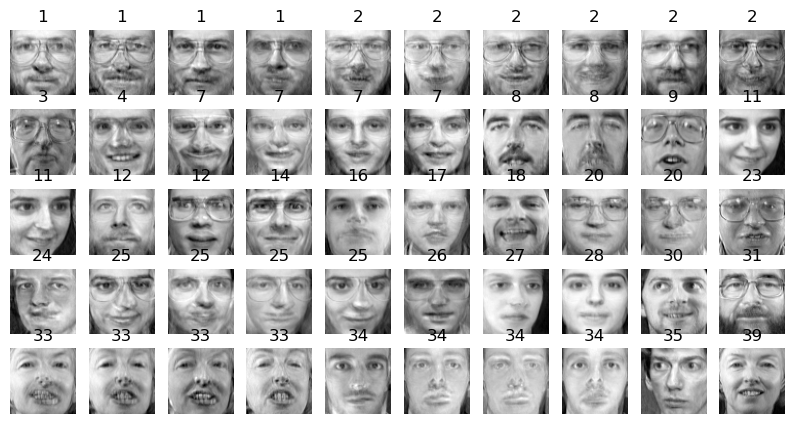

In [20]:
plot_faces(generated_faces, generated_faces_labels)

## Detecting Anomalies
Gaussian mixture model considers an instance an anomaly if it is located in low-density region in a cluster. The greater the score, the higher the sensity and lesser chance of that being an anomaly.

In [22]:
X_train.shape

(280, 4096)

In [23]:
X_train[:4].reshape(-1, 64, 64).shape

(4, 64, 64)

In [24]:
np.transpose(X_train[:4].reshape(-1, 64, 64), axes=[0, 2, 1]).shape

(4, 64, 64)

In [25]:
# Now, let's creates few faces (by modifying the existing ones) and checks if the model
# considers these as anomalies.

# Rotates 4 faces
n_rotated = 4
rotated_faces = np.transpose(
    X_train[:n_rotated].reshape(-1, 64, 64),           # Reshapes selected faces into 2-dimensional
    axes=[0, 2, 1]                                     # Last two axes will be interchanged to transpose
)
rotated_faces = rotated_faces.reshape(-1, 64*64)             # Flattens back the rotated faces 
y_rotated_faces = y_train[:n_rotated]                  # Gets the actual target/labels of the faces for later reference

# Flips 3 faces
n_flipped = 3
flipped_faces = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]  # Pixels 2-dimensional faces get flipped vertically for all columns
flipped_faces = flipped_faces.reshape(-1, 64*64)                        # Flattens back the flipped faces
y_flipped_faces = y_train[:n_flipped]                             # Gets the actual target/labels of the faces for later reference

n_darkened = 3
darkened_faces = X_train[:n_darkened].copy()           # Gets copies first before pixel manipulation
darkened_faces[:, 1:-1] *= 0.2                         # Reduces the pixel intensities by 80%
y_darkened_faces = y_train[:n_darkened]                # Gets the actual target/labels of the faces for later reference

X_modified_faces = np.r_[rotated_faces, flipped_faces, darkened_faces] # Joins the flattened sequences of 1-D arrays of faces along the row axis.
y_modified_faces = np.concatenate(
    [y_rotated_faces, y_flipped_faces, y_darkened_faces])              # Joins a sequence of 1-D arrays of face labels along an existing axis.


In [26]:
print("Shape of rotated_faces", rotated_faces.shape)
print("Shape of flipped_faces", flipped_faces.shape)
print("Shape of darkened_faces", darkened_faces.shape)
print("Shape of X_modified_faces", X_modified_faces.shape)
print("Shape of y_modified_faces", y_modified_faces.shape)

Shape of rotated_faces (4, 4096)
Shape of flipped_faces (3, 4096)
Shape of darkened_faces (3, 4096)
Shape of X_modified_faces (10, 4096)
Shape of y_modified_faces (10,)


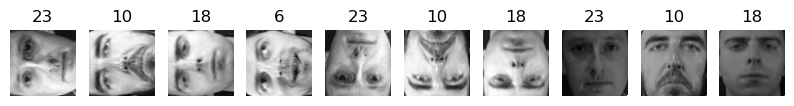

In [27]:
# Plots the modified faces
plot_faces(X_modified_faces, y_modified_faces)

In [28]:
# Gets the reduced dataset for the modified faces
X_modified_faces_reduced = pca.transform(X_modified_faces)

# Prints the new shape
print(X_modified_faces_reduced.shape)

(10, 200)


In [29]:
# Model calculates the log of probability density estimate (PDF) for each given instance
log_pdf_modified_faces = gaussian_mixture.score_samples(X_modified_faces_reduced)

print("Scores of the modified faces:", log_pdf_modified_faces)

Scores of the modified faces: [-4.60897973e+07 -3.17453356e+07 -3.02468574e+07 -4.73996568e+07
 -3.17358564e+07 -5.27950671e+07 -4.90635928e+07 -1.60735626e+08
 -1.43595404e+08 -1.41368649e+08]


These negative numbers indicate that these instances are predicted to be located at low-density region and hence can be considered as anomalies.

In [31]:
# Now, let's compare the scores for few of the training instances
print(gaussian_mixture.score_samples(X_train_reduced[:10]).round(2))

[1123.84 1126.45 1126.45 1176.66 1139.6  1146.18 1007.56 1118.9  1131.05
 1160.16]


These are positive indicating these are to be located at the high-density region in respective cluster and are highly unlikely to be anomalies.

**Observations**:
1. Gaussian mixture is a generative model capable of generating new samples from multiple distribution it has learned.
2. It can be used to detect anomalies by scoring the samples and checking if these indicates samples' location in low-density region making them highly likely to be anomalies.